In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install import-ipynb
%cd /content/drive/My\ Drive/Colab\ Notebooks/RetinaSmartCamera/notebooks

/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/notebooks


In [3]:
import import_ipynb
import RetinaUtils as ru

import DataLoaders

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data.dataset import Dataset, Subset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter

import re
import os

importing Jupyter notebook from RetinaUtils.ipynb
importing Jupyter notebook from DataLoaders.ipynb


In [4]:
def pad(x, amount):
    padding = np.zeros((amount))
    vec = np.zeros((125930,3))
    for i in range(3):
        vec[:,i]=np.hstack((padding,x[:,i],padding))
    return vec
    #return np.hstack((padding, x, padding))

def img_to_vector(img, R, padding):
    batches = 8
    img = img.view(8,1920,1080,3)
    #img = img.cpu().numpy()

    x = img.shape[2]/2
    y = img.shape[1]/2
    fixation = (y,x)

    vector_batches = torch.empty(batches, 3,50000,1)
    
    for i in range(0, batches):
        
        V = R.sample(img[i].cpu(), fixation)
        
        #V = pad(V, padding)
        
        V = np.reshape(V, (3, len(V), 1))
        V = torch.from_numpy(V)
        
        vector_batches[i,:,:] = V

    #print(vector_batches.shape)
    #vector_batches.to(device)
    return vector_batches

['Cortex', 'CudaCortex', 'CudaRetina', 'Retina', '__builtins__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'chdir', 'convert_from_gpu', 'convert_to_gpu', 'ctypes', 'get_ipython', 'getcwd', 'ir', 'lib', 'lib_path', 'listdir', 'loadPickle', 'normal_round', 'np', 'pad', 'path', 'pickle', 'project', 'sys']


In [70]:
#Test
R = ru.Retina()

#impath = "/content/drive/My Drive/Colab Notebooks/RetinaVision/botw.jpg"
impath = "/content/drive/My Drive/RODframes2/RODframes/train/bag/light/original_fixationcrop/frame1.png"
img = cv2.imread(impath,0)
x = img.shape[1]/2
y = img.shape[0]/2
fixation = (y,x)

data_dir = '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/retina_data/'
R.loadLoc(data_dir+'ret50k_loc.pkl')
R.loadCoeff(data_dir+'ret50k_coeff.pkl')
R.prepare(img.shape, fixation)

V = R.sample(img, fixation)

In [63]:
print(img.shape)

(1080, 1920)


In [8]:
class RetinaEncoder(nn.Module):
    def __init__(self):
        super(RetinaEncoder, self).__init__()

        self.layer1 = nn.Sequential(nn.Linear(50000, 5000),
                                   nn.Linear(5000, 3000),
                                   nn.Linear(3000, 2000),
                                   #nn.Linear(5000, 2000)
                                   )
        self.layer2 = nn.Sequential(nn.Linear(2000, 3000),
                                   nn.Linear(3000, 5000),
                                   nn.Linear(5000, 50000),
                                   #nn.Linear(20000, 50000)
                                   )
        #self.conv1 = nn.Conv1d(1, 3, kernel_size=3)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        #x = self.conv1(x)
        return x
m = RetinaEncoder()

In [16]:
v = torch.from_numpy(V).float()
out = m(v)

torch.FloatTensor


In [ ]:
from DataLoaders import get_dataloader
dataloader = get_dataloader(image_type='original', skip=10, batch_size=8, shuffle=False)

In [ ]:
cortical_images = get_dataloader(image_type='original_corticalimages',skip=10, batch_size=8, shuffle=False)

In [69]:
R = ru.Retina()

x = 1920/2
y = 1080/2
fixation = (y,x)

data_dir = '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/retina_data/'
R.loadLoc(data_dir+'ret50k_loc.pkl')
R.loadCoeff(data_dir+'ret50k_coeff.pkl')
R.prepare((1080,1920), fixation)

In [13]:
#from ConvAutoencoder import run_model, plot_fig, imshow

retinaEncoder = RetinaEncoder()
#mixedModel = MixedModel(retinaEncoder, convModel)

In [14]:
def load_img_vectors(dataloader):
    vectors = []
    j=0
    for data in iter(dataloader['train']):
        if j%100==0:
            
            print("Iteration {}".format(j))
        j += 1
        images, _ = data 
        images = images.view(8, 1080,1920)
        x = images.shape[2]/2
        y = images.shape[1]/2
        fixation = (y,x)

        vector_batches = torch.empty(8, 1,50000)
        for i in range(0, 8):
            V = R.sample(images[i]*255, fixation)
            #V = pad(V, 37965)
            #V = np.reshape(V, (3, len(V), 1))
            V = torch.from_numpy(V)
            vector_batches[i,:] = V

        vectors.append(vector_batches)
    return vectors

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vectors = load_img_vectors(dataloader)

Iteration 0
Iteration 100
Iteration 200
Iteration 300


In [16]:
test_v = vectors[0][0]
print(test_v.shape)

C = ru.Cortex()

cortex_dir = '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/retina_data/cortex_data/'

C.loadLocs(cortex_dir+'50k_Lloc.pkl', cortex_dir+'50k_Rloc.pkl')
C.loadCoeffs(cortex_dir+'50k_Lcoeff.pkl', cortex_dir+'50k_Rcoeff.pkl')

torch.Size([1, 50000])


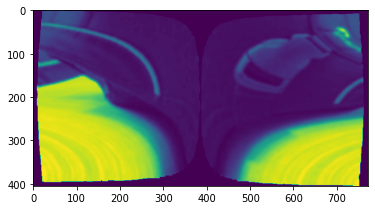

In [71]:
imshow(C.cort_img(V))

In [39]:
test_set = iter(dataloader['train'])
test_img = next(test_set)[0][0]

tensor([[115., 109., 106.,  ...,  41.,  41.,  41.],
        [115., 111., 109.,  ...,  41.,  41.,  41.],
        [125., 121., 123.,  ...,  40.,  40.,  40.],
        ...,
        [154., 154., 154.,  ..., 135., 135., 134.],
        [154., 154., 154.,  ..., 136., 136., 132.],
        [154., 154., 154.,  ..., 136., 136., 135.]])
[[109 103 100 ... 104 107 111]
 [102 102  99 ... 102 102 104]
 [102 104  99 ... 105 105 105]
 ...
 [173 172 173 ... 168 169 169]
 [173 174 175 ... 167 168 169]
 [174 175 175 ... 168 167 168]]
[  6.66602554   6.96037354   6.99922272 ... 195.25486544 195.37503049
 195.38024283]


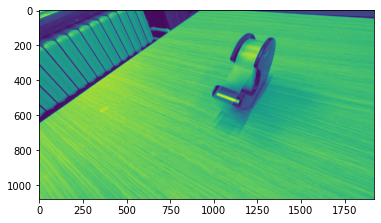

In [68]:

imshow(test_img)
x = test_img.shape[1]/2
y = test_img.shape[0]/2
fixation = (y, x)
print(test_img*255)
print(img)
test_v = R.sample(test_img*255,fixation)
print(np.unique(test_v))

In [ ]:
final_model = run_model(mixedModel, vectors, model_name='mixed_model', epochs=20, log_dir='log')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='log' --host localhost

In [24]:
def imshow(img):
    plt.imshow(img)
    #plt.imshow(np.transpose(img, (1, 2, 0)))

def plot_fig(input_img, output, epoch, iteration):
    fig = plt.figure(figsize=(24,4))
    input_img = input_img.cpu().numpy(),

    #Size of Cortical Image
    output_img = output.view(8, 3, 257, 490)
    output_img = output_img.cpu().detach().numpy()

    print(input_img[0][0].shape, output_img[0].shape)
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    imshow(input_img[0][0])
    plt.title('Input image at epoch: {}, iteration: {}'.format(epoch, iteration))
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    imshow(output_img[0])
    plt.title('Output image at epoch: {}, iteration: {}'.format(epoch, iteration))

    return fig

def run_model(model, dataloader, model_name, epochs=5, log_dir='log'):
    criterion = nn.MSELoss()

    # specify loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    model.to(device)

    writer = SummaryWriter(log_dir=log_dir)

    avg_train_loss = []
    avg_val_loss = []
    
    best = 1000000

    for epoch in range(1, epochs+1):
        i = 0
        #Train model
        model.train()
        train_loss=0

        out_images = iter(cortical_images['train'])
        for data in dataloader:
            true_cortical = next(out_images)
            true_cortical = true_cortical[0].to(device)
            images = data
            images = images.to(device)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            outputs = model(images)
            
            #print(outputs.shape)
            loss = criterion(outputs, true_cortical)
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)
            
            
            if i%99 == 0:
                print("Epoch: {}, Iteration: {}".format(epoch, i))
                writer.add_scalars(main_tag='Training loss', global_step=epoch * len(dataloader) + i, 
                                   tag_scalar_dict={'Training loss' : train_loss})

                writer.add_figure('Input vs output', plot_fig(images, 
                                                              outputs,
                                                              epoch, i+1),
                                  global_step=epoch * len(dataloader) + i)

            i += 1
        
        avg = train_loss/len(dataloader)
        if avg < best:
            best = avg
            torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/best_'+model_name+'.pt')
        
        avg_train_loss.append(avg)

        print('----- Epoch ', epoch, '-----')
        print('Train accuracy: ', avg_train_loss[epoch-1])
        #print('Validation accuracy: ', avg_val_loss[epoch-1])
  
    for i in range(1, len(avg_train_loss) + 1):
        writer.add_scalars(main_tag='Accuracy/Loss', global_step=i, tag_scalar_dict={
            'Training loss' : avg_train_loss[i-1],
            })
    
    writer.close()

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/final_'+model_name+'.pt')

    return model

In [ ]:
writer.close()

NameError: ignored